# Multiple Fields of Crop Biomass through the Planet Subscriptions API
In the  `Crop_Biomass_Example.ipynb` Jupyter Notebook, we show how to create a subscription for the Crop Biomass Planetary Variable for a single field and visualize its outputs. In practice, however, one often wants to create a subscription for multiple fields. In this notebook, we demonstrate how to do this.

For more information on working with Planetary Variables in the Subscriptions API or how to visualize Crop Biomass data, see:
- 📚 [Subscribing to Planetary Variables](https://developers.planet.com/docs/subscriptions/pvs-subs/)
- 📚 [Crop Biomass specifications](https://developers.planet.com/docs/planetary-variables/crop-biomass/)
- 📚 [Crop Biomass Example Jupyter Notebook](https://github.com/planetlabs/notebooks/blob/master/jupyter-notebooks/Subscriptions-API/crop_biomass/Crop_Biomass_Example.ipynb)


## Before you start
To be able to run this code, you will need:
1. 🔑 A Planet API key. See: [Find Your API Key](https://developers.planet.com/quickstart/apis/#find-your-api-key)
2. 📦 A (virtual) environment with a recent (>= 3.8) Python installation and the following packages:
   - [Planet SDK for Python](https://planet-sdk-for-python-v2.readthedocs.io/en/latest/get-started/quick-start-guide/#step-1-install-python-37-and-a-virtual-environment)
   - [GeoPandas](https://geopandas.org/en/stable/)
   - [Matplotlib](https://matplotlib.org/) (optional)
3. 🌍 Access to the `BIOMASS-PROXY_V4.0_10` product.
4. (Optional) Configured credentials for a cloud storage provider (Google Cloud Platform, Amazon Web Services, Microsoft Azure, or Oracle Collaboration Suite).

Below you will find a workflow to subscribe and retrieve Crop Biomass data for a set of fields in a provided GeoJSON. You can adjust the code to use your chosen cloud storage provider as required, but you can also choose to not specify the delivery parameter, if you are only interested in time series data. 

ℹ️ The notebook is written for Python 3.8 or greater and is based on the Planet Software Development Kit ([Planet SDK documentation](https://planet-sdk-for-python-v2.readthedocs.io)).

## Getting the data
First we import the required libraries:

In [18]:
import base64
import datetime as dt
from getpass import getpass
from io import StringIO

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from planet import Auth, Session
from planet.clients.subscriptions import SubscriptionsClient
from planet.subscription_request import build_request, planetary_variable_source
from shapely.geometry import mapping

### Credentials
The next step is to [authenticate with Planet services](https://planet-sdk-for-python-v2.readthedocs.io/en/latest/python/sdk-guide/#authenticate-with-planet-services). When running the following code you will be prompted to enter your [Planet API Key](https://developers.planet.com/quickstart/apis/#find-your-api-key), which will be stored securely for making the subsequent calls to the Subscriptions API.

In [19]:
api_key = getpass('Enter your API key:')
auth = Auth.from_key(api_key)

### Read your geometries
ℹ️ In your [Planet account dashboard](https://www.planet.com/account/#/dashboard), you can check your provisioned data - for this walkthrough, you will need to have access to the Crop Biomass data product. 

ℹ️ Make sure that your geometries are within your allocated quota, which represents the amount of data you can request for your areas of interest (AOIs). Before requesting data, you need to reserve quota for your AOIs using the [Quota API](https://developers.planet.com/docs/apis/quota/) or [Features Manager](https://developers.planet.com/docs/apps/features-manager/). This ensures that the data you request fits within your quota limits. You can monitor your remaining quota and current usage directly from the [dashboard]((https://www.planet.com/account/#/dashboard)) or the [Quota API](https://developers.planet.com/docs/apis/quota/). 

Using the GeoPandas library, we read the GeoJSON that contains the geometries of the fields for which we want to create a subscription. In addition, we add a `uuid` column that will contain the UUID of the subscription once it is created, and a `status` column that indicates its [status](https://developers.planet.com/docs/subscriptions/#subscription-status).

In [20]:
# Get the geometry from a geojson file
fields_geojson="my_geometries.geojson"
gdf = gpd.read_file(fields_geojson)
gdf['uuid'] = None  # For now, we don't have a uuid so we set all items to None
gdf['status'] = 'to_process'

Run the cell below to check what the GeoDataFrame looks like:

In [21]:
gdf.head()

,id,name,geometry,uuid,status
0,1,Field 1,"POLYGON ((5.64627 52.49355, 5.64553 52.4942, 5...",None,to_process
1,2,Field 2,"POLYGON ((5.64353 52.49605, 5.64335 52.49626, ...",None,to_process
2,3,Field 3,"POLYGON ((5.64271 52.49691, 5.64135 52.49819, ...",None,to_process


### Define Cloud Storage Delivery

In this example, we will deliver our data directly to a Google Cloud Storage bucket. Below, we specify the delivery location and provide our authentication credentials. These credentials must have read/write permissions on the specified bucket. For instructions on creating a service account key with the appropriate permissions, refer to the [Google Cloud documentation](https://cloud.google.com/iam/docs/keys-create-delete#iam-service-account-keys-create-console). If you are using AWS, Azure, or OCS, please use the corresponding credentials for those platforms.

You can view the [supported delivery options](https://developers.planet.com/docs/subscriptions/delivery/#supported-delivery-options) or consult the [API reference](https://developers.planet.com/docs/subscriptions/reference/#tag/subscriptions/operation/createSubscription) to review the configuration options for different cloud storage providers. This example specifically uses Google Cloud Storage.

💡 **Tip:** If you do not want to deliver your rasters to cloud storage and only want to use the time series data, provide the `delivery_config_gcp` as an empty `dict`, as shown in the last line of the cell below.


In [22]:
# Only for Cloud Storage Delivery
bucket_name="<YOUR BUCKET NAME>"
GOOGLE_APPLICATION_CREDENTIALS="~/.config/gcloud/application_default_credentials.json" # Adjust to your json file location for a GCP service account key with Cloud Storage permission

# Credentials are expected in base64 format -the following reads the json key as bytes,
# applies the base64 encoding and decodes back to a python str
with open(GOOGLE_APPLICATION_CREDENTIALS, "rb") as f:
    gcs_credentials_base64 = base64.b64encode(f.read()).decode()

# Your GCP bucket and credentials to save rasters
delivery_config_gcp = {
    "type": "google_cloud_storage",
    "parameters": {
        "bucket": bucket_name,
        "credentials": gcs_credentials_base64,
    }
}

# If you do not want a cloud storage delivery, specify the delivery_config as an empty dict
# delivery_config_gcp = {}

## Define and Create Your Subscription(s)

Now that everything is set up, we will create a subscription for each individual field. In the cell below, we iterate over each row (field) in the GeoDataFrame, create a subscription object, post it, and update the `uuid` and `status` of the subscription. If a subscription fails for any reason, you can re-run the cell, and only the failed subscription will be recreated.

ℹ️ Note that the GeoJSON file containing your geometries is updated in this step, to make sure UUIDs are not only stored in this notebook, but also in your file itself. 


In [25]:
start_date = dt.datetime(2020, 1, 1)
end_date = dt.datetime(2023, 12, 31)

for row, items in gdf.iterrows(): 
    
    if gdf.loc[row, 'status'] == "to_process" or gdf.loc[row, 'status'] == "failed":
        
        # Create a subscription source for each field
        pv_source = planetary_variable_source(
            var_type='biomass_proxy',
            var_id="BIOMASS-PROXY_V4.0_10", 
            geometry=mapping(gdf.loc[row, "geometry"]),  # Convert the shapely geometry to a JSON-like dict
            start_time=start_date,
            end_time=end_date,
        )

        # With the subscription source, we can build a request
        subscription_name = f"CB_{gdf.loc[row, "name"]}"
        request = build_request(subscription_name, source=pv_source, delivery=delivery_config_gcp)
        
        try:  # Try to submit the request, and update the GeoDataFrame with the returned subscription UUID and status
            async with Session(auth=auth) as sess:
                cl = SubscriptionsClient(sess)
                subscription_desc = await cl.create_subscription(request)
            gdf.loc[row, 'uuid']=subscription_desc['id']
            gdf.loc[row, 'status']=subscription_desc['status']
            print(f"{subscription_desc['id']} named {subscription_desc['name']} created")

        except Exception as e:  # If the request fails, log this in the GeoDataFrame, so we can retry later
            print(f"Failed to create subscription for field: '{gdf.loc[row, 'name']}', with message: {e}")
            gdf.loc[row, 'uuid']="failed"
        
    else:
        print(f"Subscription for {gdf.loc[row, 'name']} already exists, with uuid: {gdf.loc[row, 'uuid']}")

# Save the GeoDataFrame with updated UUIDs and statuses to the existing GeoJSON file
gdf.to_file(fields_geojson, driver='GeoJSON')

8e6930d4-2afb-4a47-9bf8-2d8e69d2f92c named CB_Field 1 created
fcfeac82-c0a2-4da6-bbd9-c604862da589 named CB_Field 2 created
e7f1cea2-1a11-485c-b08b-2ba3c0002a2d named CB_Field 3 created


In [26]:
gdf.head()

,id,name,geometry,uuid,status
0,1,Field 1,"POLYGON ((5.64627 52.49355, 5.64553 52.4942, 5...",8e6930d4-2afb-4a47-9bf8-2d8e69d2f92c,preparing
1,2,Field 2,"POLYGON ((5.64353 52.49605, 5.64335 52.49626, ...",fcfeac82-c0a2-4da6-bbd9-c604862da589,preparing
2,3,Field 3,"POLYGON ((5.64271 52.49691, 5.64135 52.49819, ...",e7f1cea2-1a11-485c-b08b-2ba3c0002a2d,preparing


### Monitor the Subscriptions

We can monitor each subscription using the cell below with the [get_subscription](https://planet-sdk-for-python-v2.readthedocs.io/en/latest/python/sdk-reference/#planet.clients.subscriptions.SubscriptionsClient.get_subscription) method. The subscription status is printed below, and it is also updated in the GeoDataFrame, and the GeoJSON file. 

💡 For more information on subscription status, please refer to the [Planet Developers documentation](https://developers.planet.com/docs/subscriptions/#subscription-status).


In [15]:
for row, items in gdf.iterrows(): 

    async with Session(auth=auth) as sess:
        cl = SubscriptionsClient(sess)
        subscription_desc = await cl.get_subscription(subscription_id=gdf.loc[row, 'uuid'])
        
    gdf.loc[row, 'status']=subscription_desc['status']
    print(f"{subscription_desc['id']} named {subscription_desc['name']} is {subscription_desc['status']}")


60688141-762f-4f55-bc0c-cbca03147084 named CB_Field 1 is completed
1fc77986-50ef-451b-bb81-006dbf17c4a7 named CB_Field 2 is completed
cfd79177-b5a1-44e6-8001-d2eb7df12ec8 named CB_Field 3 is completed


In [ ]:
# Save the GeoDataFrame with updated statuses to the existing GeoJSON file
gdf.to_file(fields_geojson, driver='GeoJSON')

### Retrieve the Data

We can start retrieving the subscription data even if the status is "running." The time series results generated for this subscription are retrieved directly in CSV format using `get_results_csv`. We can then use the Pandas library to read this data into a DataFrame for further analysis. Since our subscription contains multiple fields, we will concatenate the field data into a single DataFrame using the UUID as the identifier.


In [16]:
data_df = pd.DataFrame()  # Initialize an empty DataFrame to store the results

for row, items in gdf.iterrows():
    
    async with Session(auth=auth) as sess:
        cl = SubscriptionsClient(sess)
        results_desc = cl.get_results_csv(subscription_id=gdf.loc[row, 'uuid'])
        results_desc_list = [i async for i in results_desc]

    try:
        row_data = pd.read_csv(StringIO("\n".join(results_desc_list)), parse_dates=["item_datetime", "local_solar_time"], index_col="local_solar_time")
        row_data["uuid"] = gdf.loc[row, "uuid"]
        row_data["name"] = gdf.loc[row, "name"]
        data_df = pd.concat([data_df, row_data])
    except:
        print(f"No data found (yet) for field: '{gdf.loc[row, 'name']}'")

# Set the datetime as the index of the DataFrame
data_df.reset_index(inplace=True)
data_df.set_index('item_datetime', inplace=True)
data_df.sort_index(inplace=True)


In [27]:
# Check how the data looks
data_df.head()

,local_solar_time,id,status,created,updated,errors,CB.band-1.mean,CB.band-1.valid_percent,item_id,source_id,uuid,name
item_datetime,,,,,,,,,,,,
2020-01-01 00:00:00+00:00,2020-01-01,a112ceb2-0152-4598-81a0-84fd8ed2b33d,SUCCESS,2024-10-08T14:08:39.077668Z,2024-10-08T14:08:39.077668Z,{},0.272,100,BIOMASS-PROXY_V4.0_10_2020-01-01T0000,BIOMASS-PROXY_V4.0_10,60688141-762f-4f55-bc0c-cbca03147084,Field 1
2020-01-01 00:00:00+00:00,2020-01-01,786dc951-484f-47a7-8bee-cebf963d2e21,SUCCESS,2024-10-08T14:01:10.522935Z,2024-10-08T14:01:10.522935Z,{},0.249,100,BIOMASS-PROXY_V4.0_10_2020-01-01T0000,BIOMASS-PROXY_V4.0_10,cfd79177-b5a1-44e6-8001-d2eb7df12ec8,Field 3
2020-01-01 00:00:00+00:00,2020-01-01,e8492370-e7e8-4189-8220-6546d330c092,SUCCESS,2024-10-08T14:57:49.521329Z,2024-10-08T14:57:49.521329Z,{},0.251,100,BIOMASS-PROXY_V4.0_10_2020-01-01T0000,BIOMASS-PROXY_V4.0_10,1fc77986-50ef-451b-bb81-006dbf17c4a7,Field 2
2020-01-02 00:00:00+00:00,2020-01-02,0505445d-66f5-422a-9e25-48afb7eee91a,SUCCESS,2024-10-08T14:08:38.97394Z,2024-10-08T14:08:38.97394Z,{},0.266,100,BIOMASS-PROXY_V4.0_10_2020-01-02T0000,BIOMASS-PROXY_V4.0_10,60688141-762f-4f55-bc0c-cbca03147084,Field 1
2020-01-02 00:00:00+00:00,2020-01-02,4141fdc3-91c8-4f8b-8a77-347e13d32c22,SUCCESS,2024-10-08T14:04:04.393288Z,2024-10-08T14:04:04.393288Z,{},0.245,100,BIOMASS-PROXY_V4.0_10_2020-01-02T0000,BIOMASS-PROXY_V4.0_10,cfd79177-b5a1-44e6-8001-d2eb7df12ec8,Field 3


### Plotting a Time Series

Now that we have all the data in the `data_df`, we can use it for analysis, such as a simple time series plot, as shown in the example below. For more visualizations, check the other [Crop Biomass Example Jupyter Notebook](https://github.com/planetlabs/notebooks/blob/master/jupyter-notebooks/Subscriptions-API/crop_biomass/Crop_Biomass_Example.ipynb), which also demonstrates how to visualize raster data.


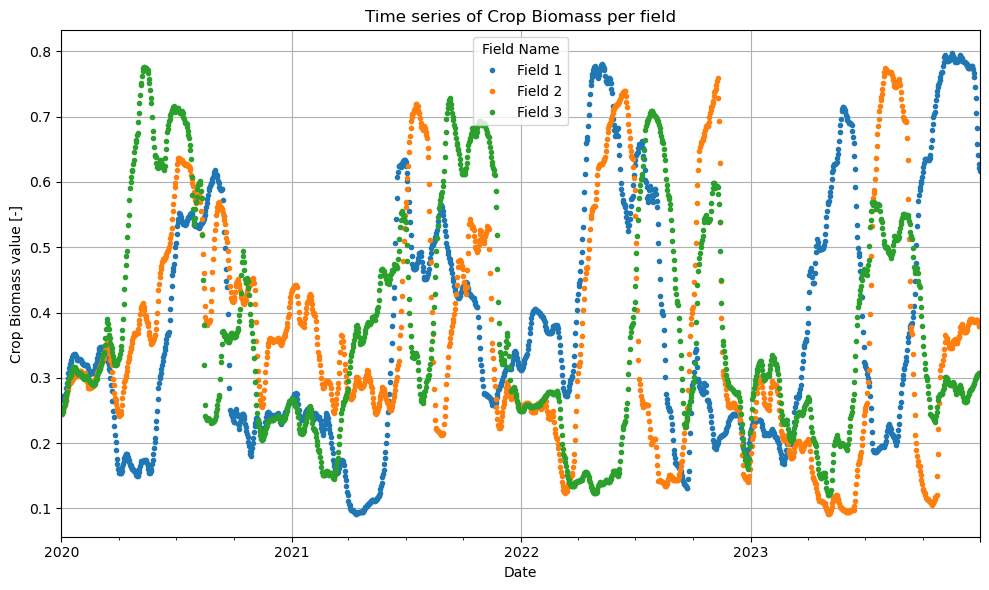

In [17]:
# Filter by valid data only
data_df = data_df[data_df["CB.band-1.valid_percent"].notnull()]
data_df = data_df[data_df["CB.band-1.valid_percent"] > 0]
data_df = data_df[data_df["status"] != 'QUEUED']

# Plot the time series of Crop Biomass per field
fig, ax = plt.subplots(figsize=(10, 6))
for name, field_df in data_df.groupby("name"):
    field_df['CB.band-1.mean'].plot(ax=ax, kind='line', style='o', label=name, markersize=3)

ax.set_xlabel('Date')
ax.set_ylabel('Crop Biomass value [-]')
ax.set_title('Time series of Crop Biomass per field')
ax.grid(True)
ax.legend(title='Field Name')
fig.tight_layout()